## Isolation Forest

### 1.¿Qué es Isolation Forest?

Por definición se entiende que un dato anómalo es aquel que tiene un comportamiento diferente a la gran mayoría y no ocurre con frecuencia, de modo que debiesen ser fáciles de identificar mediante técnicas de aislamiento. El algoritmo Isolation Forest se basa en esta idea y procesa los datos usándo métodos que aislan los datos ( un principio completamente distinto en relación a los clustering tradicionales, donde el foco está en agrupar datos en base a su proximidad o densidad). Otra ventaja de esta altlernativa es que no ve perjudicada la calidad de sus resultados por problemas de datos desbalanceados. En lo que concierne a performance, el algoritmo no requiere mucha memoria para ejecutarse y llega a resultados en tiempos razonables, siendo así una alternativa escalable.

### 2.¿Cómo funciona?

> Concepto base del algoritmo: Aislar un dato anómalo debiese ser fácil

Recorre todos los puntos del dataset de manera individual y va creando segmentaciones a partir de columnas que selecciona de manera aleatoria, al finalizar calcula el score de aislación, el cual corresponde al número de iteraciones que fueron necesarias para poder aislar el punto. El resultado de este algoritmo es muy similar a un Random Forest.



Fuentes

- https://quantdare.com/isolation-forest-algorithm/
- https://medium.com/@hyunsukim_9320/isolation-forest-step-by-step-341b82923168
- https://quantdare.com/isolation-forest-algorithm/

### 3. Probando el algoritmo

#### 3.1 Creando el Dataset
Lo primero será tener un dataset de prueba, para ello se utilizarán los generadores de datos diponibles en [scikit-learn](https://scikit-learn.org/stable/modules/classes.html#samples-generator). Para el primer test basta con tener nubes de puntos. El dataset resultante consta de 2 variables y  5.000 registros, los cuales se dividen en 3 labels. Al revisar cada variable por separado queda la impresión que estas tienen un comportamiento normal y no posee gran cantidad de valores atípicos que deban ser eliminados. Para acidificar la prueba, se inyectarán 500 valores aleatorios en todo el plano, con el fin de que hagan de valores atípicos.

In [125]:
from sklearn.ensemble import IsolationForest
from sklearn.datasets.samples_generator import make_blobs
import numpy as np
import pandas as pd
import seaborn as sns
import random
import matplotlib.pyplot as plt
import hdbscan
from datetime import datetime

In [152]:
def grafico_resultado(startTime,endtime,data,category):

    print("Tiempo de ejecución: ", endtime- startTime)
    gs = plt.GridSpec(1,2,plt.figure(figsize=(15, 5)))

    plt.subplot(gs[0,0])
    sns.scatterplot(data=data,x=0,y=1,hue=category,palette="RdBu_r")

    plt.subplot(gs[0,1])
    sns.countplot(data=data,x=category,palette="GnBu_d")

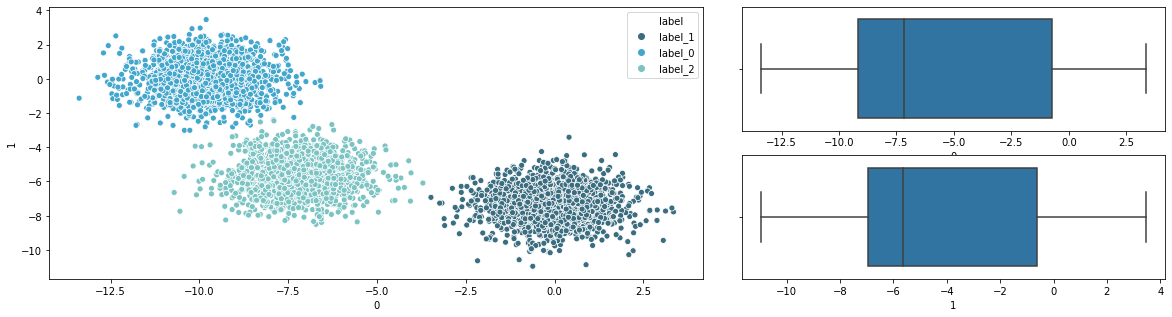

In [146]:
blobs, labels = make_blobs(n_samples=5000, n_features=2,centers=3,random_state=9)
data_original=pd.DataFrame(blobs)
l=pd.DataFrame(data=labels,columns=["label"])
l['label']= l['label'].apply(lambda x: "label_"+str(x))

data_original=data_original.join(l)

f=plt.figure(figsize=(20, 5))

gs = plt.GridSpec(2,5,f)
plt.subplot(gs[:,0:3])
sns.scatterplot(data=data_original,x=0,y=1,hue='label',palette="GnBu_d")

plt.subplot(gs[0,3:5])
sns.boxplot(data=data_original,x=0)

plt.subplot(gs[1,3:5])
ax=sns.boxplot(data=data_original,x=1)

In [140]:
adicionales=[]
for i in range(0,500):
    ranx=( 1+random.uniform(0, 1))*random.randrange(round(data_original[0].min(),0), round(data_original[0].max(),0))+random.uniform(0, 1)
    rany=(( 1+random.uniform(0, 1)))*random.randrange(round(data_original[1].min(),0), round(data_original[1].max(),0))+random.uniform(0, 1)
    punto=[ranx,rany ]   
    adicionales.append(punto)
    
ad=pd.DataFrame(adicionales)
ad['label']='outlier'
data_real= data_original.append(ad) 

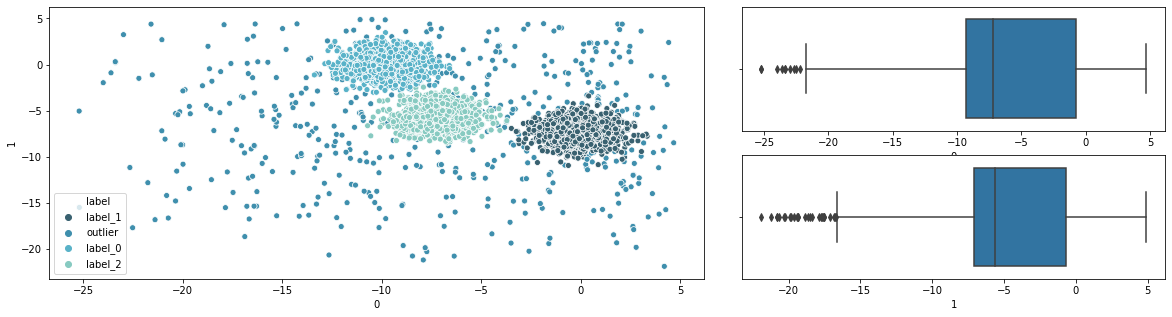

In [147]:
f=plt.figure(figsize=(20, 5))

gs = plt.GridSpec(2,5,f)
plt.subplot(gs[:,0:3])
sns.scatterplot(data=data_real,x=0,y=1,hue='label',palette="GnBu_d")

plt.subplot(gs[0,3:5])
sns.boxplot(data=data_real,x=0)

plt.subplot(gs[1,3:5])
ax=sns.boxplot(data=data_real,x=1)

#### 3.1 Probando borrado de atípicos por IQR

Dado que la primera técnica que se utiliza para revisar presencia de atípicos es el resultado del boxplot, inicialmente se usará el criterio de IQR para limpiar los datos


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.


Tiempo de ejecución:  0:00:00.030202


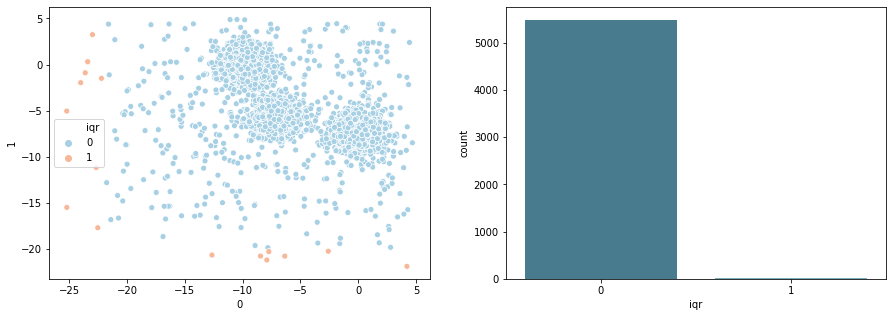

In [153]:
startTime = datetime.now()

q1 = data_real[[0,1]].quantile(0.25)
q3 = data_real[[0,1]].quantile(0.75)
iqr = q3 - Q1

out=data_real[((data_real[[0,1]] < (q1 - 1.5 * iqr)) |(data_real[[0,1]] > (q3 + 1.5 * iqr))).any(axis=1)]
out['iqr']="1"
no_out=data_real[~((data_real[[0,1]] < (q1 - 1.5 * iqr)) |(data_real[[0,1]] > (q3 + 1.5 * iqr))).any(axis=1)]
no_out['iqr']="0"

data_real=no_out.append(out)
endtime= datetime.now() 

grafico_resultado(startTime,endtime,data_real,"iqr")

#### 3.2 Clusterizando con HDBSCAN


A modo de comparación, primero se ejecutará un [HDBSCAN](https://hdbscan.readthedocs.io/en/latest/how_hdbscan_works.html) para tener una referencia del comportamiento de un modelo de clustering que en términos generales tiene buenos resultados.

Tiempo de ejecución:  0:00:00.124097


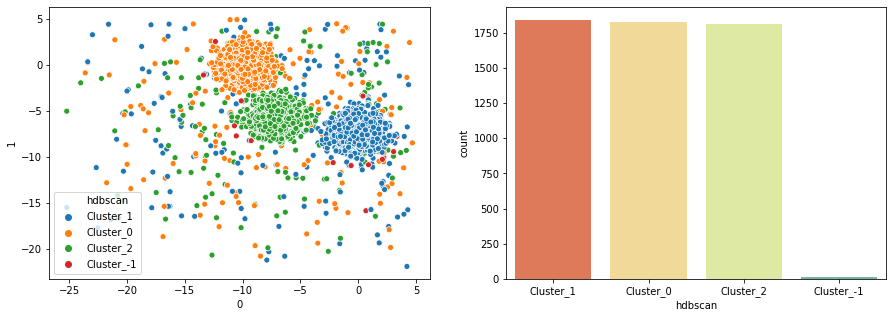

In [143]:
features =data_real.columns.tolist()
features.remove('label')

startTime = datetime.now()
clusterer=hdbscan.HDBSCAN(min_samples=20,min_cluster_size=10)
labels = clusterer.fit_predict(data_real[features])
endtime= datetime.now() 

labels_hdbscan=pd.DataFrame(data=labels,columns=["hdbscan"])
labels_hdbscan['hdbscan']=labels_hdbscan['hdbscan'].apply(lambda x: "Cluster_"+str(x))
data_real=data_real.join(labels_hdbscan)

grafico_resultado(startTime,endtime,data_real,"hdbscan")

#### 3.3 Isolation Forest

Finalente, probando los resultados del algoritmo. 

Si bien su tiempo de ejecución es algo superior al HDBSCAN, los resultados son significamente mejores respecto a limpieza de atípicos

/usr/local/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:247: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)
/usr/local/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:415: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)


Tiempo de ejecución:  0:00:00.629357


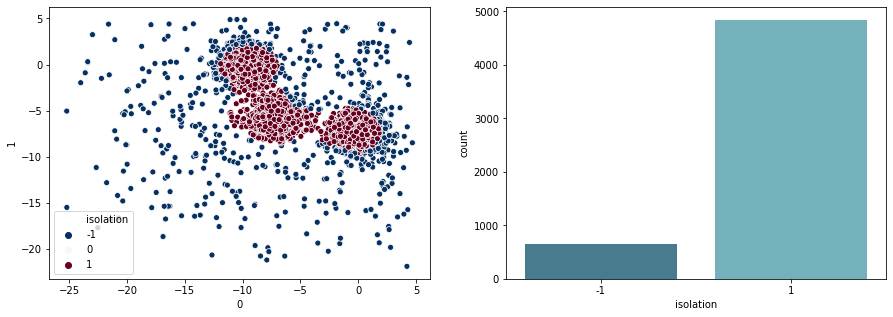

In [154]:
startTime = datetime.now()
isolation=IsolationForest(n_estimators=100, max_samples='auto', contamination=float(.12),max_features=1.0, n_jobs=-1, random_state=42, verbose=0)
isolation.fit(data_real[[0,1]])
pred = isolation.predict(data_real[[0,1]])
endtime= datetime.now() 

data_real['isolation']= pred

grafico_resultado(startTime,endtime,data_real,"isolation")